In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import chi2

## Example 1 - Bernoulli(p)

In [2]:
def wald_ber_two_side(sample_size,h0,p_true,alpha=0.05):
    critical_value = norm.ppf(1-alpha/2)
    result = pd.DataFrame(columns=['w','sample_size','h_0','reject'])
    n_experiment = 1000
    w            = [np.nan]*n_experiment
    reject       = [np.nan]*n_experiment
    for i in range(n_experiment):
        sample      = np.random.binomial(n=1,p=p_true,size=sample_size)
        sample_mean = np.mean(sample)
        phat        = sample_mean
        w[i]        = abs((phat-h0)/np.sqrt(sample_mean*(1-sample_mean)/sample_size))
        reject[i] = int(w[i]>=critical_value)
    result['w']           = w
    result['sample_size'] = sample_size
    result['h_0']         = h0
    result['reject']      = reject
    return(result)

def lr_ber_two_side(sample_size,h0,p_true,alpha=0.05):
    critical_value = chi2.ppf(1-alpha, 1)
    result = pd.DataFrame(columns=['lr','sample_size','h_0','reject'])
    n_experiment = 1000
    lr           = [np.nan]*n_experiment
    reject       = [np.nan]*n_experiment
    for i in range(n_experiment):
        sample      = np.random.binomial(n=1,p=p_true,size=sample_size)
        sample_mean = np.mean(sample)
        phat        = sample_mean
        sample_sum  = np.sum(sample) 
        lr[i] =2*(np.log(phat/h0)*sample_sum+np.log((1-phat)/(1-h0))*(sample_size-sample_sum))
        reject[i] = int(lr[i]>=critical_value)
    result['lr']          = lr
    result['sample_size'] = sample_size
    result['h_0']         = h0
    result['reject']      = reject
    return(result)

def wald_lr_compare(sample_size_list,h0,p_true):
    compare_result = pd.DataFrame(columns = ['sample_size','true_p','h0',
                                             'rejection_rate_wald','rejection_rate_lr',
                                            ])
    for ss in range(len(sample_size_list)):
        ss_now = sample_size_list[ss]
        
        compare_result.loc[ss,'sample_size']    = ss_now
        compare_result.loc[ss,'true_p']         = p_true
        compare_result.loc[ss,'h0']             = h0
        
        result_wald = wald_ber_two_side(sample_size=ss_now, h0=h0, p_true=p_true)
        reject_rate_wald = result_wald['reject'].mean()
        compare_result.loc[ss,'rejection_rate_wald'] = reject_rate_wald
        result_lr   = lr_ber_two_side(sample_size=ss_now, h0=h0, p_true=p_true)
        reject_rate_lr   = result_lr['reject'].mean()
        compare_result.loc[ss,'rejection_rate_lr'] = reject_rate_lr

        if h0==p_true:
            error_rate_wald = reject_rate_wald
            error_rate_lr   = reject_rate_lr
            compare_result.loc[ss,'type_1_error_wald'] = error_rate_wald
            compare_result.loc[ss,'type_1_error_lr']   = error_rate_lr
        else: 
            error_rate_wald = 1 - reject_rate_wald
            error_rate_lr   = 1 - reject_rate_lr
            compare_result.loc[ss,'type_2_error_wald'] = error_rate_wald
            compare_result.loc[ss,'type_2_error_lr']   = error_rate_lr
    return(compare_result)

### Consider the following null hypotheses (which are false).
#### - The type 2 error rates of the two tests are close, with different sample sizes. 
#### - As the sample size increases, the Type 2 error (failing to reject a false null hypothesis) decreases.
#### - As the values in the false null hypothesis get closer to the true values, a larger sample size is required to reject the null hypothesis.

In [3]:
sample_size_list = [20,50,100,200,400,1000]
h0_list          = [0.41,0.43,0.45,0.5,0.6]
p_true           = 0.4
for h0 in h0_list:
    compare_now = wald_lr_compare(sample_size_list,h0,p_true)
    if h0==h0_list[0]:
        compare_final = compare_now
    else:
        compare_final = pd.concat([compare_final,compare_now],axis=0)

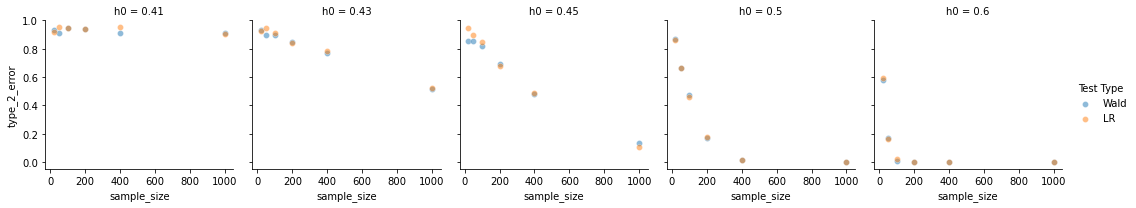

In [4]:
df_w = compare_final[['sample_size','h0','type_2_error_wald']].rename(columns={'type_2_error_wald':'type_2_error'})
df_w['Test Type'] = 'Wald'
df_lr = compare_final[['sample_size','h0','type_2_error_lr']].rename(columns={'type_2_error_lr':'type_2_error'})
df_lr['Test Type'] = 'LR'
combined = pd.concat([df_w,df_lr],axis=0) 
g = sns.FacetGrid(data=combined,hue='Test Type',col='h0')
g.map(sns.scatterplot,'sample_size','type_2_error',alpha=0.5)
g.add_legend()
plt.show()

### Consider the null hypotheses (which is true)
#### - The type 1 error of these two tests are generally close - around 5% to 10%.

In [5]:
sample_size_list = [20,50,100,200,400,1000]
h0_list          = [0.4]
p_true      = 0.4
for h0 in h0_list:
    compare_now = wald_lr_compare(sample_size_list,h0,p_true)
    if h0==h0_list[0]:
        compare_final = compare_now
    else:
        compare_final = pd.concat([compare_final,compare_now],axis=0)

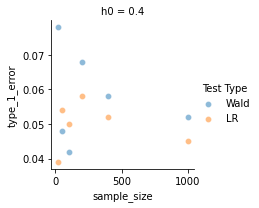

In [6]:
df_w = compare_final[['sample_size','h0','type_1_error_wald']].rename(columns={'type_1_error_wald':'type_1_error'})
df_w['Test Type'] = 'Wald'
df_lr = compare_final[['sample_size','h0','type_1_error_lr']].rename(columns={'type_1_error_lr':'type_1_error'})
df_lr['Test Type'] = 'LR'
combined = pd.concat([df_w,df_lr],axis=0) 
g = sns.FacetGrid(data=combined,hue='Test Type',col='h0')
g.map(sns.scatterplot,'sample_size','type_1_error',alpha=0.5)
g.add_legend()
plt.show()

## Example 2 - Binomial(K,p)
#### Take K as given (K=5)

In [7]:
def wald_bino_two_side(sample_size,k,h0,p_true,alpha=0.05):
    critical_value = norm.ppf(1-alpha/2)
    result = pd.DataFrame(columns=['w','sample_size','h_0','reject'])
    n_experiment = 1000
    w            = [np.nan]*n_experiment
    reject       = [np.nan]*n_experiment
    for i in range(n_experiment):
        sample      = np.random.binomial(n=k,p=p_true,size=sample_size)
        sample_mean = np.mean(sample)
        phat        = sample_mean/k
        w[i]        = np.sqrt(sample_size*k**3)*abs(phat-h0)/np.sqrt(sample_mean*(k-sample_mean))
        reject[i] = int(w[i]>=critical_value)
    result['w']           = w
    result['sample_size'] = sample_size
    result['h_0']         = h0
    result['reject']      = reject
    return(result)

def lr_bino_two_side(sample_size,k,h0,p_true,alpha=0.05):
    critical_value = chi2.ppf(1-alpha,1)
    result = pd.DataFrame(columns=['lr','sample_size','h_0','reject'])
    n_experiment = 1000
    lr           = [np.nan]*n_experiment
    reject       = [np.nan]*n_experiment
    for i in range(n_experiment):
        sample      = np.random.binomial(n=k,p=p_true,size=sample_size)
        sample_mean = np.mean(sample)
        phat        = sample_mean/k
        sample_sum  = np.sum(sample) 
        lr[i]       = 2*(np.log(phat/h0)*sample_sum+np.log((1-phat)/(1-h0))*(sample_size*k-sample_sum))
        reject[i] = int(lr[i]>=critical_value)
    result['lr']          = lr
    result['sample_size'] = sample_size
    result['h_0']         = h0
    result['reject']      = reject
    return(result)

def wald_lr_compare(sample_size_list,k,h0,p_true):
    compare_result = pd.DataFrame(columns = ['sample_size','true_p','h0',
                                             'rejection_rate_wald','rejection_rate_lr',
                                            ])
    for ss in range(len(sample_size_list)):
        ss_now = sample_size_list[ss]
        
        compare_result.loc[ss,'sample_size']    = ss_now
        compare_result.loc[ss,'true_p']         = p_true
        compare_result.loc[ss,'h0']             = h0
        
        result_wald = wald_bino_two_side(sample_size=ss_now, k=k, h0=h0, p_true=p_true)
        reject_rate_wald = result_wald['reject'].mean()
        compare_result.loc[ss,'rejection_rate_wald'] = reject_rate_wald
        result_lr   = lr_bino_two_side(sample_size=ss_now, k=k, h0=h0, p_true=p_true)
        reject_rate_lr   = result_lr['reject'].mean()
        compare_result.loc[ss,'rejection_rate_lr'] = reject_rate_lr

        if h0==p_true:
            error_rate_wald = reject_rate_wald
            error_rate_lr   = reject_rate_lr
            compare_result.loc[ss,'type_1_error_wald'] = error_rate_wald
            compare_result.loc[ss,'type_1_error_lr']   = error_rate_lr
        else: 
            error_rate_wald = 1 - reject_rate_wald
            error_rate_lr   = 1 - reject_rate_lr
            compare_result.loc[ss,'type_2_error_wald'] = error_rate_wald
            compare_result.loc[ss,'type_2_error_lr']   = error_rate_lr
    return(compare_result)

### Consider the following null hypotheses (which are false).
#### The findings are similar with those in Example 1. 

In [8]:
sample_size_list = [20,50,100,200,400,1000]
h0_list          = [0.41,0.43,0.45,0.5,0.6]
p_true           = 0.4
k                = 5
for h0 in h0_list:
    compare_now = wald_lr_compare(sample_size_list,k,h0,p_true)
    if h0==h0_list[0]:
        compare_final = compare_now
    else:
        compare_final = pd.concat([compare_final,compare_now],axis=0)

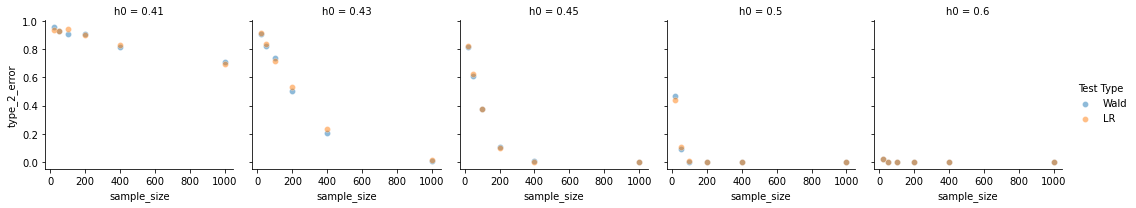

In [9]:
df_w = compare_final[['sample_size','h0','type_2_error_wald']].rename(columns={'type_2_error_wald':'type_2_error'})
df_w['Test Type'] = 'Wald'
df_lr = compare_final[['sample_size','h0','type_2_error_lr']].rename(columns={'type_2_error_lr':'type_2_error'})
df_lr['Test Type'] = 'LR'
combined = pd.concat([df_w,df_lr],axis=0) 
g = sns.FacetGrid(data=combined,hue='Test Type',col='h0')
g.map(sns.scatterplot,'sample_size','type_2_error',alpha=0.5)
g.add_legend()
plt.show()

### Consider the null hypotheses (which is true)
#### - The type 1 error of these two tests are generally close - around 5%.

In [10]:
sample_size_list = [20,50,100,200,400,1000]
h0_list          = [0.4]
p_true      = 0.4
for h0 in h0_list:
    compare_now = wald_lr_compare(sample_size_list,k,h0,p_true)
    if h0==h0_list[0]:
        compare_final = compare_now
    else:
        compare_final = pd.concat([compare_final,compare_now],axis=0)

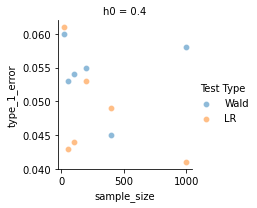

In [11]:
df_w = compare_final[['sample_size','h0','type_1_error_wald']].rename(columns={'type_1_error_wald':'type_1_error'})
df_w['Test Type'] = 'Wald'
df_lr = compare_final[['sample_size','h0','type_1_error_lr']].rename(columns={'type_1_error_lr':'type_1_error'})
df_lr['Test Type'] = 'LR'
combined = pd.concat([df_w,df_lr],axis=0) 
g = sns.FacetGrid(data=combined,hue='Test Type',col='h0')
g.map(sns.scatterplot,'sample_size','type_1_error',alpha=0.5)
g.add_legend()
plt.show()

## Example 3 - Poisson(Lambda)

In [12]:
def wald_poiss_two_side(sample_size,h0,lambda_true,alpha=0.05):
    critical_value = norm.ppf(1-alpha/2)
    result = pd.DataFrame(columns=['w','sample_size','h_0','reject'])
    n_experiment = 1000
    w            = [np.nan]*n_experiment
    reject       = [np.nan]*n_experiment
    for i in range(n_experiment):
        sample      = np.random.poisson(lam=lambda_true,size=sample_size)
        sample_mean = np.mean(sample)
        lambdahat   = sample_mean
        w[i]        = np.sqrt(sample_size)*abs(lambdahat-h0)/np.sqrt(sample_mean)
        reject[i]   = int(w[i]>=critical_value)
    result['w']           = w
    result['sample_size'] = sample_size
    result['h_0']         = h0
    result['reject']      = reject
    return(result)

def lr_poiss_two_side(sample_size,h0,lambda_true,alpha=0.05):
    critical_value = chi2.ppf(1-alpha, 1)
    result = pd.DataFrame(columns=['lr','sample_size','h_0','reject'])
    n_experiment = 1000
    lr           = [np.nan]*n_experiment
    reject       = [np.nan]*n_experiment
    for i in range(n_experiment):
        sample      = np.random.poisson(lam=lambda_true,size=sample_size)
        sample_mean = np.mean(sample)
        lambdahat   = sample_mean
        sample_sum  = np.sum(sample) 
        lr[i]       = 2*(np.log(lambdahat/h0)*sample_sum-sample_size*(lambdahat-h0))
        reject[i]   = int(lr[i]>=critical_value)
    result['lr']          = lr
    result['sample_size'] = sample_size
    result['h_0']         = h0
    result['reject']      = reject
    return(result)

def wald_lr_compare(sample_size_list,h0,lambda_true):
    compare_result = pd.DataFrame(columns = ['sample_size','true_p','h0',
                                             'rejection_rate_wald','rejection_rate_lr',
                                            ])
    for ss in range(len(sample_size_list)):
        ss_now = sample_size_list[ss]
        
        compare_result.loc[ss,'sample_size']    = ss_now
        compare_result.loc[ss,'true_p']         = p_true
        compare_result.loc[ss,'h0']             = h0
        
        result_wald = wald_poiss_two_side(sample_size=ss_now, h0=h0, lambda_true=lambda_true)
        reject_rate_wald = result_wald['reject'].mean()
        compare_result.loc[ss,'rejection_rate_wald'] = reject_rate_wald
        result_lr   = lr_poiss_two_side(sample_size=ss_now, h0=h0, lambda_true=lambda_true)
        reject_rate_lr   = result_lr['reject'].mean()
        compare_result.loc[ss,'rejection_rate_lr'] = reject_rate_lr

        if h0==lambda_true:
            error_rate_wald = reject_rate_wald
            error_rate_lr   = reject_rate_lr
            compare_result.loc[ss,'type_1_error_wald'] = error_rate_wald
            compare_result.loc[ss,'type_1_error_lr']   = error_rate_lr
        else: 
            error_rate_wald = 1 - reject_rate_wald
            error_rate_lr   = 1 - reject_rate_lr
            compare_result.loc[ss,'type_2_error_wald'] = error_rate_wald
            compare_result.loc[ss,'type_2_error_lr']   = error_rate_lr
    return(compare_result)

### Consider the following null hypotheses (which are false).
#### The findings are similar with those in Example 1. 

In [13]:
sample_size_list = [20,50,100,200,400,1000]
h0_list          = [3,4,4.5,5.5,6,7]
lambda_true      = 5
for h0 in h0_list:
    compare_now = wald_lr_compare(sample_size_list,h0,lambda_true)
    if h0==h0_list[0]:
        compare_final = compare_now
    else:
        compare_final = pd.concat([compare_final,compare_now],axis=0)

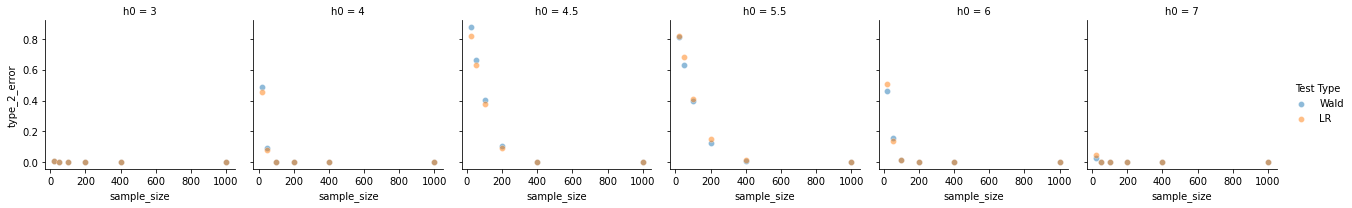

In [14]:
df_w = compare_final[['sample_size','h0','type_2_error_wald']].rename(columns={'type_2_error_wald':'type_2_error'})
df_w['Test Type'] = 'Wald'
df_lr = compare_final[['sample_size','h0','type_2_error_lr']].rename(columns={'type_2_error_lr':'type_2_error'})
df_lr['Test Type'] = 'LR'
combined = pd.concat([df_w,df_lr],axis=0) 
g = sns.FacetGrid(data=combined,hue='Test Type',col='h0')
g.map(sns.scatterplot,'sample_size','type_2_error',alpha=0.5)
g.add_legend()
plt.show()

### Consider the null hypotheses (which is true)
#### - The type 1 error of these two tests are generally close - around 5%.

In [15]:
sample_size_list = [20,50,100,200,400,1000]
h0_list          = [5]
lambda_true      = 5
for h0 in h0_list:
    compare_now = wald_lr_compare(sample_size_list,h0,lambda_true)
    if h0==h0_list[0]:
        compare_final = compare_now
    else:
        compare_final = pd.concat([compare_final,compare_now],axis=0)

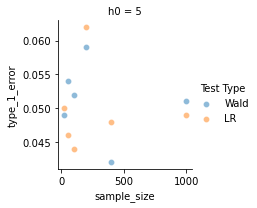

In [16]:
df_w = compare_final[['sample_size','h0','type_1_error_wald']].rename(columns={'type_1_error_wald':'type_1_error'})
df_w['Test Type'] = 'Wald'
df_lr = compare_final[['sample_size','h0','type_1_error_lr']].rename(columns={'type_1_error_lr':'type_1_error'})
df_lr['Test Type'] = 'LR'
combined = pd.concat([df_w,df_lr],axis=0) 
g = sns.FacetGrid(data=combined,hue='Test Type',col='h0')
g.map(sns.scatterplot,'sample_size','type_1_error',alpha=0.5)
g.add_legend()
plt.show()

## Example 4 - Uniform(a,b)

In [17]:
def lr_uniform(sample_size,h0,b_true):
    a = 0
    n_experiment = 1000
    lr           = [np.nan]*n_experiment
    for i in range(n_experiment):
        sample = np.random.uniform(a,b_true,sample_size)
        bhat   = sample.max()
        lr[i]   = 2*sample_size*np.log(h0/bhat)
    return(lr)
def lr_poiss(sample_size,h0,lambda_true):
    n_experiment = 1000
    lr           = [np.nan]*n_experiment
    for i in range(n_experiment):
        sample      = np.random.poisson(lam=lambda_true,size=sample_size)
        sample_mean = np.mean(sample)
        lambdahat   = sample_mean
        sample_sum  = np.sum(sample) 
        lr[i]       = 2*(np.log(lambdahat/h0)*sample_sum-sample_size*(lambdahat-h0))
    return(lr)
def plot_lr_add_chisquare(lr_data,distribution):
    plt.hist(lr_data,density=True,label='LR test statistic')
    x = np.linspace(0, 20, 100)
    pdf_chi1 = chi2.pdf(x, df=1)
    pdf_chi2 = chi2.pdf(x, df=2)
    plt.plot(x, pdf_chi1, 'red', label='Chi-square(dof=1) PDF')
    plt.plot(x, pdf_chi2, 'green', label='Chi-square(dof=2) PDF')
    plt.legend()
    plt.title(distribution)
    plt.show()

### sample size = 10

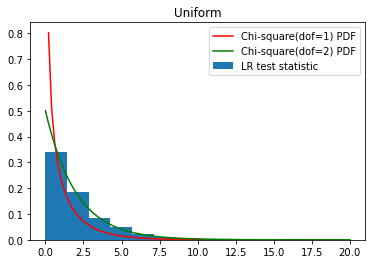

In [18]:
sample_size = 10
uniform_lr  = lr_uniform(sample_size=10,h0=10,b_true=10)
plot_lr_add_chisquare(uniform_lr,'Uniform')

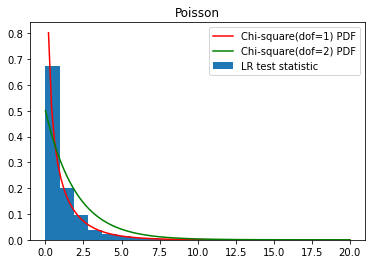

In [19]:
sample_size = 10
poiss_lr  = lr_poiss(sample_size=10,h0=5,lambda_true=5)
plot_lr_add_chisquare(poiss_lr,'Poisson')

### sample size = 50

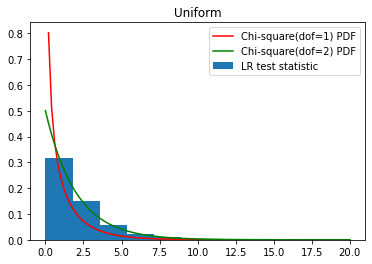

In [20]:
sample_size = 50
uniform_lr  = lr_uniform(sample_size=10,h0=10,b_true=10)
plot_lr_add_chisquare(uniform_lr,'Uniform')

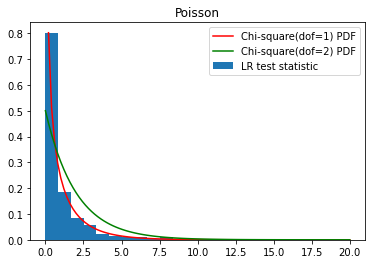

In [21]:
sample_size = 50
poiss_lr  = lr_poiss(sample_size=10,h0=5,lambda_true=5)
plot_lr_add_chisquare(poiss_lr,'Poisson')

### sample size = 500

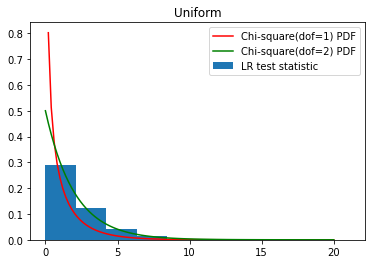

In [22]:
sample_size = 500
uniform_lr  = lr_uniform(sample_size=10,h0=10,b_true=10)
plot_lr_add_chisquare(uniform_lr,'Uniform')

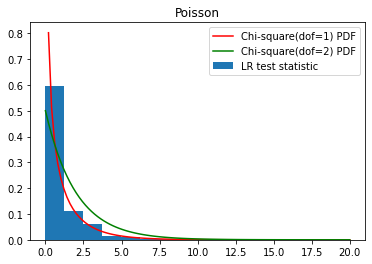

In [23]:
sample_size = 500
poiss_lr  = lr_poiss(sample_size=10,h0=5,lambda_true=5)
plot_lr_add_chisquare(poiss_lr,'Poisson')